In [1]:
import os, time, random, math, pickle, json, shutil
from pathlib import Path
from datetime import datetime

import torch, torchvision
from torchinfo import summary
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

In [58]:
DATA_FILE          = "dots100k_128.pt"   # path to the .pt with {"frames","disp"}
BATCH_SZ           = 256
NUM_EPOCHS         = 15
LR                 = 2e-4
WEIGHT_DECAY       = 1e-4
RESNET_DEPTH       = 18       # choose 18, 34, 50, 101 …
PRETRAINED         = False    # if True, load ImageNet weights then patch 1st conv
USE_GRAYSCALE      = False    # if True, convert f0,f1,diff to 1-channel each

TRAIN_FRACTION     = 0.8      # 80 % train, 10 % val, 10 % test
VAL_FRACTION       = 0.1

DEVICE             = "cuda" if torch.cuda.is_available() else "cpu"

# Experiment folder
EXP_DIR = Path(f"experiments/exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
EXP_DIR.mkdir(parents=True, exist_ok=True)
print(f"Logging to → {EXP_DIR.resolve()}")

Logging to → C:\Users\Owner\Documents\FlowCount\experiments\exp_20250602_160724


## Prepare Dataset

In [3]:
class DotPairDataset(Dataset):
    """
    Each item:
        x : Tensor  (C,H,W)  where C = 9 (RGB) or 3 (grayscale)
        y : scalar  int32    total horizontal displacement
    """
    def __init__(self, frames_uint8, disp_int32, grayscale=False):
        assert frames_uint8.dtype == torch.uint8
        self.F   = frames_uint8
        self.disp = disp_int32
        self.gray = grayscale

    def __len__(self):
        return self.disp.shape[0]

    def _to_float(self, img_uint8):
        return img_uint8.float().div_(255.)  # → [0,1]

    def __getitem__(self, idx):
        f0_u8 = self.F[idx]       # (3,H,W) uint8
        f1_u8 = self.F[idx+1]
        diff  = (f1_u8.to(torch.int16) - f0_u8.to(torch.int16)).clamp_(-255,255)
        diff_u8 = (diff + 255).to(torch.uint8)   # shift to 0..510, still uint8

        if not self.gray:
            x = torch.cat([f0_u8, f1_u8, diff_u8], dim=0)   # (9,H,W)
        else:
            to_gray = lambda im: (0.299*im[0] + 0.587*im[1] + 0.114*im[2]).unsqueeze(0)
            g0 = to_gray(f0_u8); g1 = to_gray(f1_u8); gd = to_gray(diff_u8)
            x = torch.cat([g0, g1, gd], dim=0)              # (3,H,W)

        x = self._to_float(x)
        y = self.disp[idx].float()                # regression target
        return x, y

In [4]:
raw = torch.load(DATA_FILE)
frames_u8, disp_i32 = raw["frames"], raw["disp"]

full_ds   = DotPairDataset(frames_u8, disp_i32, grayscale=USE_GRAYSCALE)

n_total   = len(full_ds)
n_train   = int(TRAIN_FRACTION * n_total)
n_val     = int(VAL_FRACTION   * n_total)
n_test    = n_total - n_train - n_val

train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test],
                                         generator=torch.Generator().manual_seed(0))

train_ld = DataLoader(train_ds, batch_size=BATCH_SZ, shuffle=True,
                      num_workers=0, pin_memory=True)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_SZ, shuffle=False,
                      num_workers=0, pin_memory=True)
test_ld  = DataLoader(test_ds,  batch_size=BATCH_SZ, shuffle=False,
                      num_workers=0, pin_memory=True)

print(f"Dataset sizes — train: {n_train}, val: {n_val}, test: {n_test}")

C:\Users\Owner\AppData\Local\Temp\ipykernel_71012\3254421575.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(DATA_FILE)


Dataset sizes — train: 80000, val: 10000, test: 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6117647..0.6117647].


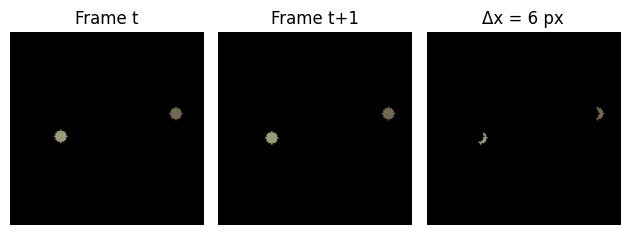

In [5]:
idx = random.randrange(len(full_ds))
(pair, label) = full_ds[idx]
f0 = pair[0:3].permute(1, 2, 0).numpy()  # (H,W,3)
f1 = pair[3:6].permute(1, 2, 0).numpy()

plt.subplot(1, 3, 1)
plt.title("Frame t")
plt.imshow(f0)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Frame t+1")
plt.imshow(f1)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Δx = {int(label.item())} px")
diff = (f1 - f0)
plt.imshow(diff)
plt.axis("off")

plt.tight_layout()
plt.show()

## Load Model

In [6]:
def get_resnet(depth=18, in_channels=9, pretrained=False):
    factory = {
        18:  torchvision.models.resnet18,
        34:  torchvision.models.resnet34,
        50:  torchvision.models.resnet50,
        101: torchvision.models.resnet101,
        152: torchvision.models.resnet152,
    }[depth]

    model = factory(weights="IMAGENET1K_V1" if pretrained else None)

    # Patch the first conv if channel count differs
    if in_channels != 3:
        w = model.conv1.weight
        model.conv1 = nn.Conv2d(in_channels, w.shape[0],
                                kernel_size=7, stride=2, padding=3, bias=False)
        if pretrained:
            # Kaiming init for new conv
            nn.init.kaiming_normal_(model.conv1.weight, mode="fan_out", nonlinearity="relu")

    # Replace classifier with 1-unit head for regression
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model

C_IN   = 3 if USE_GRAYSCALE else 9
net    = get_resnet(RESNET_DEPTH, in_channels=C_IN, pretrained=PRETRAINED).to(DEVICE)
criterion = nn.L1Loss()
optim     = torch.optim.AdamW(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

summary(net)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            28,224
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,72

## Train Model

In [7]:
def run_epoch(model, loader, train=True):
    if train: model.train()
    else:     model.eval()

    total_loss, n_samples = 0.0, 0
    with torch.set_grad_enabled(train):
        for x, y in tqdm(loader, desc="Batch"):
            x, y = x.to(DEVICE), y.to(DEVICE).unsqueeze(1)  # (B,1)
            pred = model(x)
            loss = criterion(pred, y)
            if train:
                optim.zero_grad(set_to_none=True)
                loss.backward()
                optim.step()
            total_loss += loss.item() * x.size(0)
            n_samples  += x.size(0)
    return total_loss / n_samples    # MAE

In [8]:
train_curve, val_curve = [], []
best_val = float("inf")

for epoch in trange(1, NUM_EPOCHS+1, desc="Epoch"):
    t0 = time.time()
    tr_loss = run_epoch(net, train_ld, train=True)
    val_loss = run_epoch(net, val_ld,   train=False)

    train_curve.append(tr_loss)
    val_curve.append(val_loss)

    # -- console log
    print(f"[{epoch:02d}/{NUM_EPOCHS}]  "
          f"train MAE {tr_loss:.4f} | val MAE {val_loss:.4f}  "
          f"({time.time()-t0:.1f}s)")

    # -- checkpointing
    last_path = EXP_DIR / "last_weights.pt"
    best_path = EXP_DIR / "best_weights.pt"
    torch.save({"epoch": epoch,
                "state_dict": net.state_dict(),
                "train_loss": tr_loss,
                "val_loss": val_loss},
               last_path)

    if val_loss < best_val:
        best_val = val_loss
        shutil.copy(last_path, best_path)
        print(f"  ↳ new best! ({best_val:.4f}) checkpointed.")

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[01/15]  train MAE 0.8795 | val MAE 1.3346  (71.3s)
  ↳ new best! (1.3346) checkpointed.


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[02/15]  train MAE 0.6433 | val MAE 0.8698  (71.4s)
  ↳ new best! (0.8698) checkpointed.


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[03/15]  train MAE 0.6128 | val MAE 4.9795  (74.2s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[04/15]  train MAE 0.6055 | val MAE 2.0340  (76.6s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[05/15]  train MAE 0.5806 | val MAE 0.5858  (75.6s)
  ↳ new best! (0.5858) checkpointed.


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[06/15]  train MAE 0.5763 | val MAE 0.7404  (71.2s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[07/15]  train MAE 0.5545 | val MAE 0.5787  (73.8s)
  ↳ new best! (0.5787) checkpointed.


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[08/15]  train MAE 0.5508 | val MAE 4.0109  (74.7s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[09/15]  train MAE 0.5443 | val MAE 2.3417  (76.2s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[10/15]  train MAE 0.5247 | val MAE 5.2432  (74.9s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[11/15]  train MAE 0.5099 | val MAE 3.4969  (73.3s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[12/15]  train MAE 0.5016 | val MAE 4.3859  (75.0s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[13/15]  train MAE 0.4877 | val MAE 2.1741  (74.4s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[14/15]  train MAE 0.4675 | val MAE 6.9917  (73.6s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[15/15]  train MAE 0.4613 | val MAE 12.4235  (73.2s)


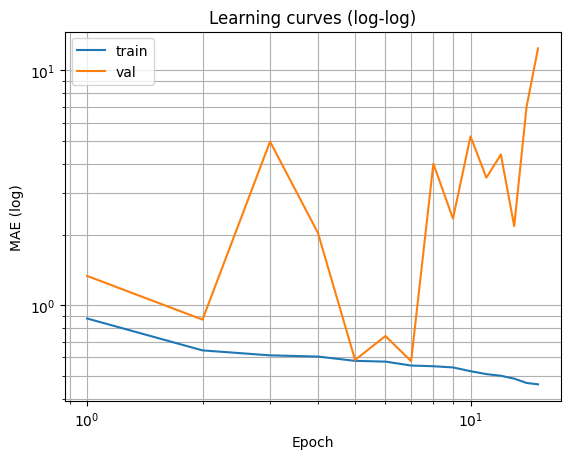

In [9]:
# -- plot log-log learning curves
steps = np.arange(1, len(train_curve)+1)
plt.figure()
plt.loglog(steps, train_curve, label="train")
plt.loglog(steps, val_curve,   label="val")
plt.xlabel("Epoch")
plt.ylabel("MAE (log)")
plt.legend()
plt.grid(True, which="both")
plt.title("Learning curves (log-log)")
plt.savefig(EXP_DIR / "loss_curve.png", dpi=150)
plt.show()

## Evaluate Model

In [59]:
net.load_state_dict(torch.load(EXP_DIR / "best_weights.pt")['state_dict'])
net.eval()

C:\Users\Owner\AppData\Local\Temp\ipykernel_71012\3979578127.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(EXP_DIR / "best_weights.pt")[

FileNotFoundError: [Errno 2] No such file or directory: 'experiments\\exp_20250602_160724\\best_weights.pt'

In [34]:
def evaluate_split(loader):
    net.eval()
    errs = []
    with torch.no_grad():
        for x, y in loader:
            pred = net(x.to(DEVICE)).cpu().squeeze(1)
            errs.append(torch.abs(pred - y).numpy())
    errs = np.concatenate(errs)
    return errs.mean(), errs.std()

mae_train, std_train = evaluate_split(train_ld)
mae_val,   std_val   = evaluate_split(val_ld)
mae_test,  std_test  = evaluate_split(test_ld)

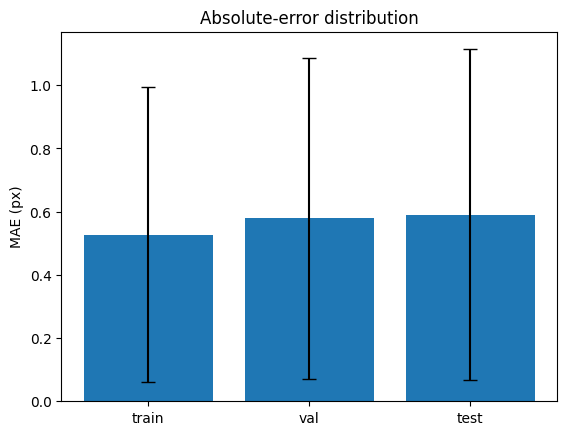

MAE  train 0.528 ± 0.466
MAE  val   0.579 ± 0.507
MAE  test  0.590 ± 0.524


In [ ]:
labels = ["train", "val", "test"]
means  = [mae_train, mae_val, mae_test]
stds   = [std_train, std_val, std_test]

plt.figure()
plt.bar(labels, means, yerr=stds, capsize=5)
plt.ylabel("MAE (px)")
plt.title("Absolute-error distribution")
plt.savefig(EXP_DIR / "error_bars.png", dpi=150)
plt.show()

print(f"MAE  train {mae_train:.3f} ± {std_train:.3f}")
print(f"MAE  val   {mae_val:.3f} ± {std_val:.3f}")
print(f"MAE  test  {mae_test:.3f} ± {std_test:.3f}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84705883..0.84705883].


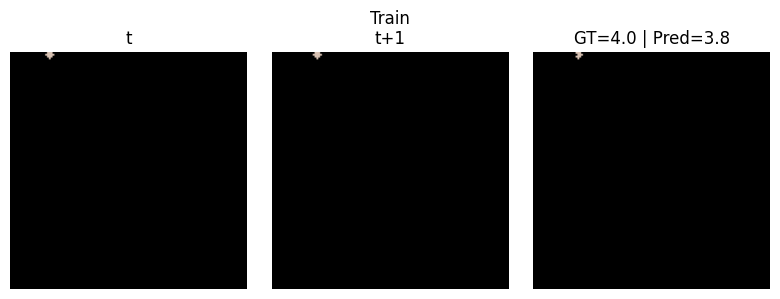

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].


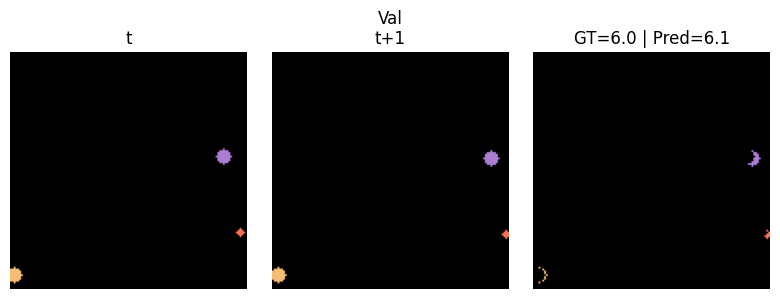

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.99215686].


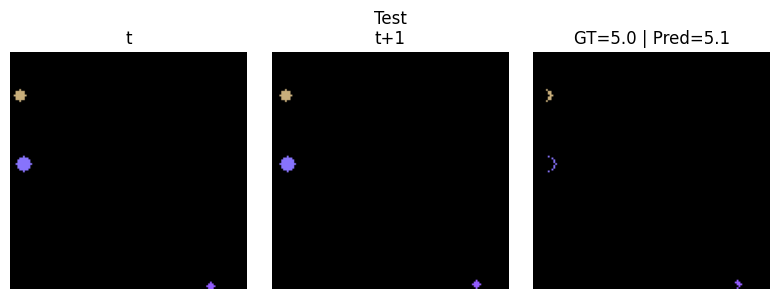

In [57]:
def show_example(dataset, title_prefix=""):
    idx = random.randrange(len(dataset))
    (x, y_true) = dataset[idx]          # x: (C,H,W) float
    f0 = x[:3] if not USE_GRAYSCALE else x[0:1].repeat(3,1,1)
    f1 = x[3:6] if not USE_GRAYSCALE else x[1:2].repeat(3,1,1)

    with torch.no_grad():
        pred = net(x.unsqueeze(0).to(DEVICE)).cpu().item()

    f0_img = f0.permute(1,2,0).numpy()
    f1_img = f1.permute(1,2,0).numpy()
    diff   = (f1_img - f0_img)

    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1); plt.imshow(f0_img); plt.title("t");     plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(f1_img); plt.title("t+1");   plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(diff, cmap="bwr", vmin=-1, vmax=1)
    plt.title(f"GT={y_true:.1f} | Pred={pred:.1f}")
    plt.axis("off")
    plt.suptitle(title_prefix)
    plt.tight_layout()
    plt.show()

# Show a few random examples from each split
for split_name, ds in [("Train", train_ds), ("Val", val_ds), ("Test", test_ds)]:
    show_example(ds, title_prefix=split_name)